# Radar and Navigation - Assignmnet 2
M.M.C.A. Marasinghe - 170376V

# Section 1

### Import libraries

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import io

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import dataset

In [51]:
path1 = "https://raw.githubusercontent.com/Akeshala/Radar-and-Navigation/main/Assignment%202/imag_component.csv"
In = pd.read_csv(path1, sep=';', header=None, squeeze=True)

path2 = "https://raw.githubusercontent.com/Akeshala/Radar-and-Navigation/main/Assignment%202/real_component.csv"
Qn = pd.read_csv(path2, sep=';', header=None, squeeze=True)

In [52]:
df = Qn + 1j * In
data = df.to_numpy()

### Set parameters

*   Number of samples = 27000
*   Pulse repetition frequency = 1800 Hz
*   Horizontal beam width = 2˚
*   Radar rotation speed = 12 RPM
*   Radar frequency = 720 MHz

*   Sampling rate = 1080 kHz
*   Range slots = 30
*   Window size for threshold detection = 21
*   Guard band size = 4

*   Speed of light = 300000000








In [53]:
# Radar parameters

Fs_original = 1080*1000 # original sampling freq 1080kHz
C = 30 # no of bins
fr = 1800 # pulse repitition freq
revol_speed = 12 # revolution speed of radar
theta_initial = 0
theta_h = 2
M = 20 # downsampling factor
N = int(len(data)/C) # number of echoes
radar_frequency = 720000000
speed_of_light = 300000000
Fs = Fs_original/M
pulse_repetition = 1800

# Section 2

## Question 01




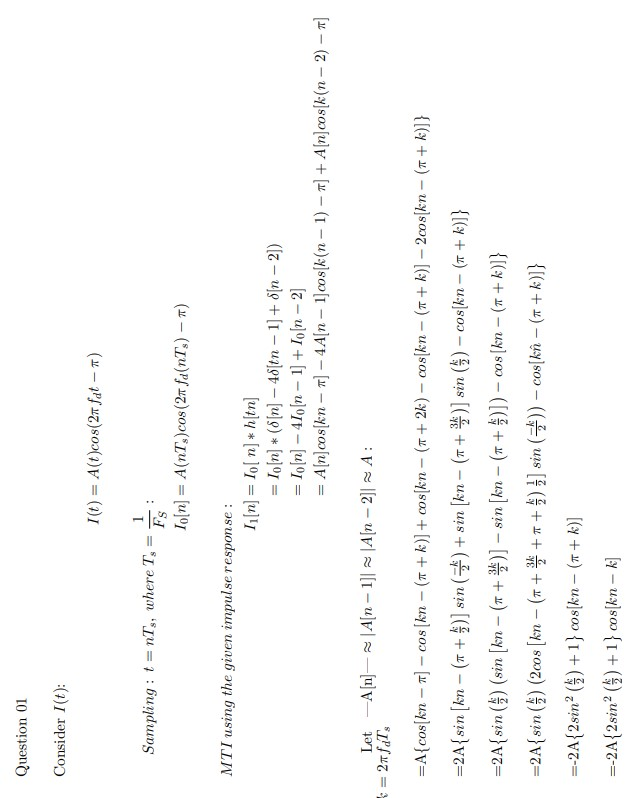

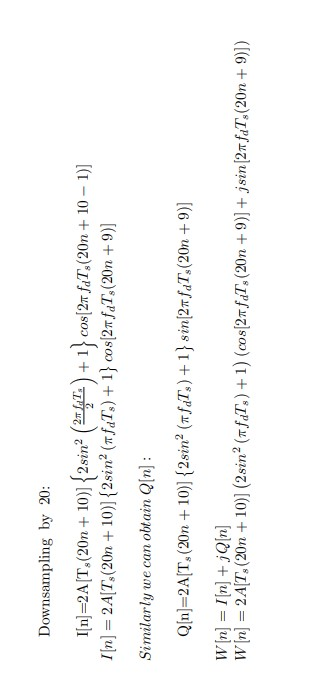

## Question 02

Data matrix can be represented from this equation $ W[n] = I[n]+jQ[n] $

Amplitude of $ W[n] $ can be calculated from: \

  >$|W[n]|= \sqrt{I[n]^2+Q[n]^2}$

Phase of $ W[n] $ can be calculated from: \

  >$ tan(\theta) = \frac{Q[n]}{I[n]} $

Ground clutter can be identied from phase as follows:

 >$I[n] = 2A[T_s(20n+10)]\left\{sin^2\left(\pi f_d T_s\right)+1\right\}cos[2\pi f_d T_s (20n+9)]$

 >$ Q[n] = 2A[T_s(20n+10)]\left\{sin^2\left(\pi f_d T_s\right)+1\right\}sin[2\pi f_d T_s (20n+9)] $

 >$ Phase = 2\pi f_d T_s (20n+9) $

 >$ f_d = \frac{2V_r}{λ} $

 Velocity of ground clutter $ = 0$

 >$ V_r \rightarrow 0 $

 >$f_d \rightarrow 0 \: :\:2\pi f_d T_s (20n+9) \rightarrow 0$

 Therefore, ground clutter has zero phase. 

 >$ if\: Phase(W[n]) < Ground\:Clutter \: Threshold:\: 0 \: otherwise\: W[n]$







In [54]:
data_matrix = data.reshape(N, C) # generating data matrix
phase_data_matrix =  np.angle(data_matrix)

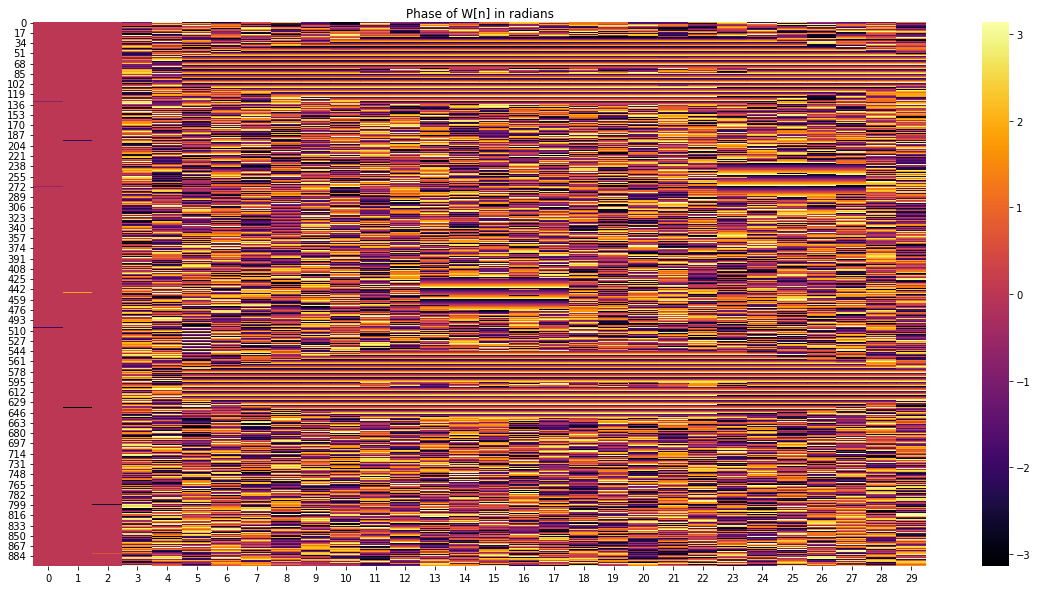

In [55]:
# Plot phase of the data_matrix
f, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title('Phase of W[n] in radians')
g1 = sns.heatmap(phase_data_matrix, annot=False, cbar=True, ax = ax1, cmap='inferno')

## Question 03


In [56]:
#@title Threshold{ display-mode: "form" }
threshold1 =   10e-4 #@param {type:"number"}

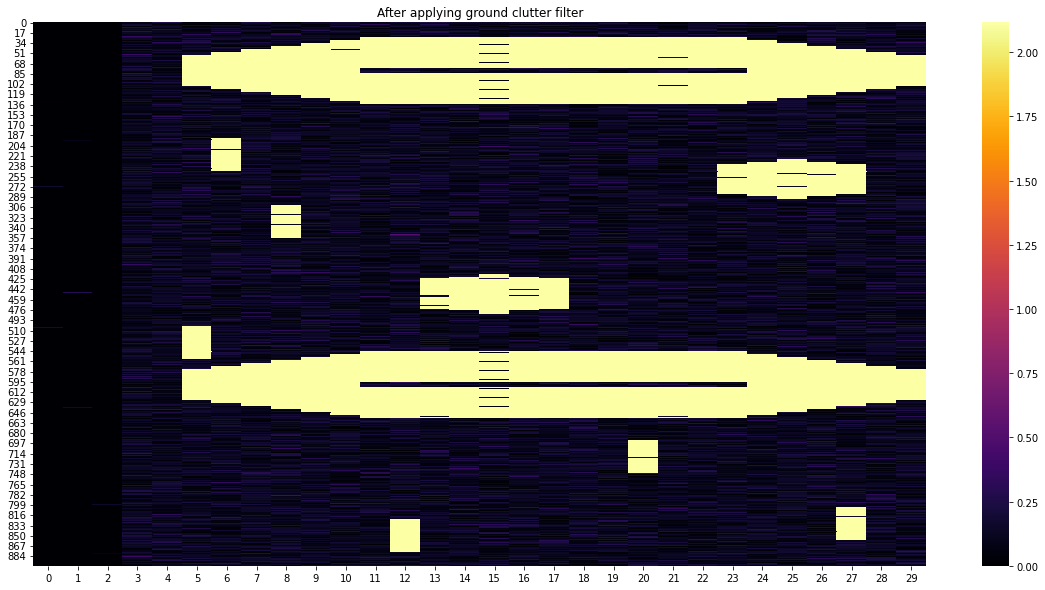

In [57]:
# Removing ground clutter

threshold1 =   10e-4
phase_data_matrix = np.angle(data_matrix)

data_matrix_clutter_removed = np.where( threshold1<abs(phase_data_matrix), data_matrix, 0)

data_matrix_clutter_removed_abs = abs(data_matrix_clutter_removed)

f,ax = plt.subplots(figsize=(20,10))

ax.set_title('After applying ground clutter filter')
ax = sns.heatmap(data_matrix_clutter_removed_abs, annot=False, cbar=True, cmap='inferno')

## Question 04

In [58]:
# Column wise FFT of data_matrix_clutter_removed 
data_matrix_FFT = np.fft.fft(data_matrix_clutter_removed, axis=0)

 >$ f_d = \frac{2V_rf}{C} $ \\
 f = radar frequency

In [59]:
# Calculate doppler frequencies from velocity
parameters = {'Cloud':[50,1.05,1], 'Ground Clutter':[0,None,2], 'Rain Clutter':[20,0.9,3], 'Birds':[35,1.05,4], 'Air-crafts':[150,0.5,5], 'No object':[None,None,0]}
frequencies = {}

for obj, vals in parameters.items():
  velocity = vals[0]
  if velocity != None:
    dopler_frequency = (2*velocity*radar_frequency)/speed_of_light
    frequencies[obj] = dopler_frequency
  else:
    frequencies[obj] = None

In [60]:
def plot_data_matrix_fft(fft, frequencies, Fs):

  fft_abs = np.abs(fft)
  f_axis = np.arange(-Fs/2, Fs/2, step=Fs/N)

  plt.figure(figsize=(30, 8))
  ax = plt.ylabel('$|W(f)|^2$')
  ax = plt.xlabel('Frequency (Hz)')
  ax = plt.title('FFT of W[n]')
  ax = plt.xticks(np.arange(-Fs/2, (Fs / 2) + (Fs*30)/N , (Fs*30)/N))  
  plt.plot(f_axis, np.concatenate((fft_abs[(N // 2):], fft_abs[:(N // 2)]), axis = 0))
  plt.show()

  return None

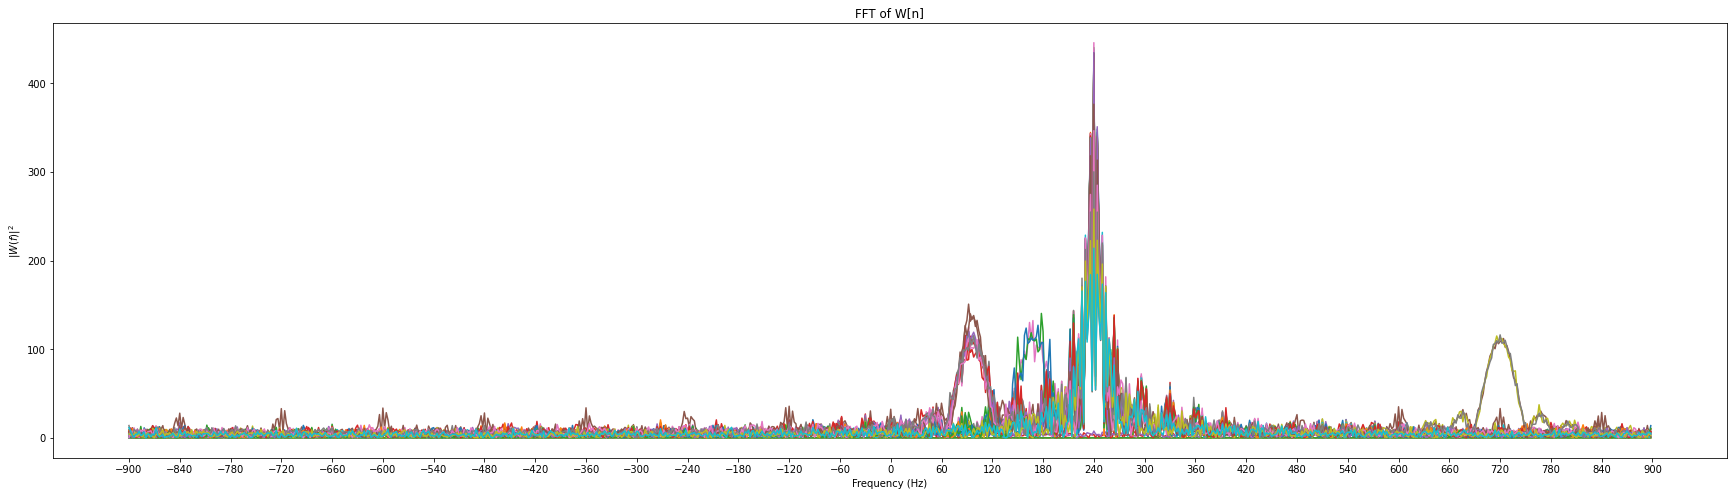

In [61]:
plot_data_matrix_fft(data_matrix_FFT, frequencies, pulse_repetition)

In [62]:
# Bandwidth in Hz 
BW = 36

for keys,vals in frequencies.items():
  if vals:
    print(keys,'frequency boundaries',vals-BW," - ",vals+BW,'Hz')

Cloud frequency boundaries 204.0  -  276.0 Hz
Rain Clutter frequency boundaries 60.0  -  132.0 Hz
Birds frequency boundaries 132.0  -  204.0 Hz
Air-crafts frequency boundaries 684.0  -  756.0 Hz


## Question 5



In [63]:
# Band pass filter
def BPF(cutoff_L,cutoff_R,fs,N,plot):

  f_pos = np.arange(0, fs / 2, step=fs / N)
  H_pos = 1. * ((f_pos >= cutoff_L) & (f_pos <= cutoff_R))
  f_neg = np.arange(-fs / 2, 0, step=fs / N)
  H_neg = 1. * ((f_pos >= cutoff_L) & (f_pos <= cutoff_R))
  
  H = np.concatenate([H_pos, np.flip(H_neg)])
  H = H.reshape(H.shape[0], 1) 
  return H  

In [64]:
# Save objects
dict_final = {}

for keys,vals in frequencies.items():

  # check for non empty values
  if vals:
    filt = BPF(vals-BW, vals+BW, fr, N, 0) # Get band pass filter

    FFT_filt = np.multiply(data_matrix_FFT,filt) # Applying filter to data matrix

    DM_dopl_filt = np.fft.ifft(FFT_filt,axis=0) # Obtain inverse fourier transform

    # Encoding
    threshold = parameters[keys][1]
    encode = parameters[keys][2]
    data_matrix_final = (abs(DM_dopl_filt)>=threshold) * encode

    dict_final[keys] = data_matrix_final

    np.savetxt( keys+".csv", data_matrix_final, delimiter="," )


# Save ground clutter
data_matrix_clutter_encoded = np.where(threshold1<abs(phase_data_matrix), 0, 2)
np.savetxt("Ground Clutter.csv", data_matrix_clutter_encoded, delimiter=",") 

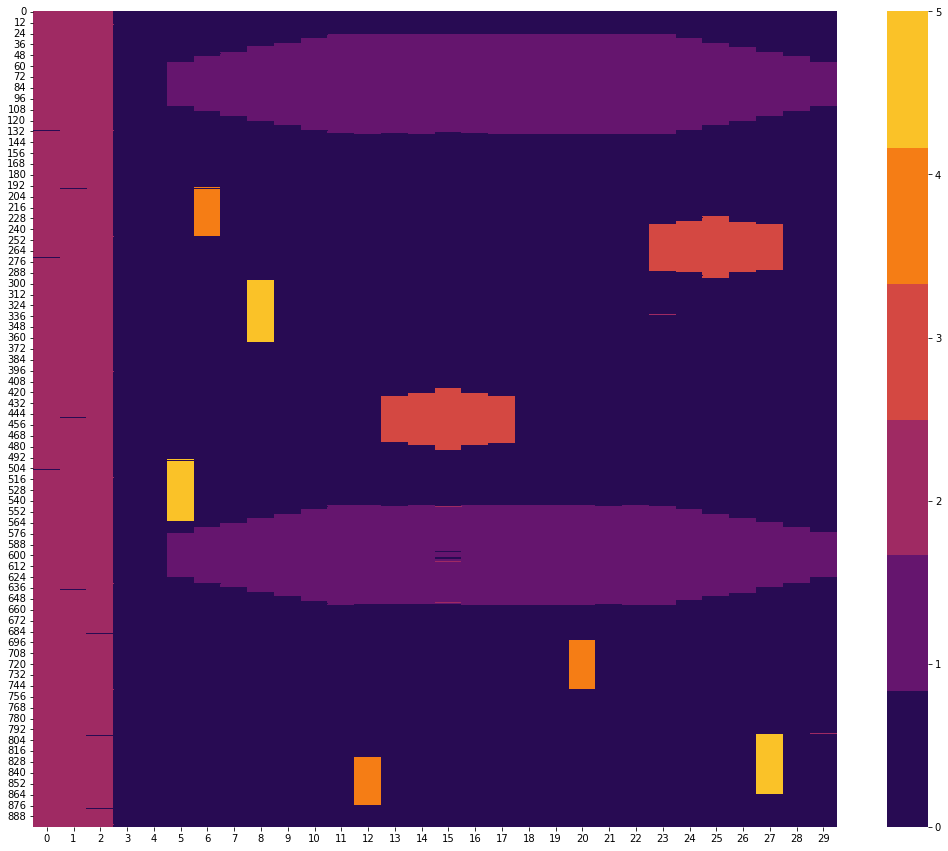

In [65]:
# Plot all objects
all_objects_matrix = data_matrix_clutter_encoded
for key,val in dict_final.items():
  data_matrix_plot = val
  all_objects_matrix = np.where(data_matrix_plot==parameters[key][2], data_matrix_plot, all_objects_matrix)

n=len(parameters)
cmap = sns.color_palette('inferno', n)
f,ax = plt.subplots(figsize=(18,15))
ax = sns.heatmap(all_objects_matrix, cmap=cmap)